In [37]:
# ============================================================================
# IMPORTS ET CONFIGURATION
# ============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

# ============================================================================
# IMPORT DES DONNÉES
# ============================================================================
df = pd.read_csv('statistiques_grandes_villes_2020_2024_toutes_colonnes.csv', sep=';')
df.columns = df.columns.str.strip()

def corriger_annee(row):
    annee = row['annee']
    ville = row['ville']
    if pd.isna(annee):
        return None
    annee = int(annee)
    if ville == 'Lyon' and 20200 <= annee <= 20240:
        return 2020 + (annee - 20200) // 10
    if ville == 'Marseille' and 38380 <= annee <= 38460:
        return {38380: 2020, 38399: 2021, 38418: 2022, 38437: 2023, 38456: 2024}.get(annee)
    if ville == 'Paris' and 46460 <= annee <= 46560:
        return {46460: 2020, 46483: 2021, 46506: 2022, 46529: 2023, 46552: 2024}.get(annee)
    if 2020 <= annee <= 2024:
        return annee
    return None

df['annee_corrigee'] = df.apply(corriger_annee, axis=1)
df = df.dropna(subset=['annee_corrigee'])
df['annee'] = df['annee_corrigee'].astype(int)

df['prix_m2_moyen'] = pd.to_numeric(df['prix_m2_moyen'], errors='coerce')
df['nb_transactions'] = pd.to_numeric(df['nb_transactions'], errors='coerce')
df = df.dropna(subset=['prix_m2_moyen', 'ville'])

villes = sorted(df['ville'].unique())
print(f"✅ Données prêtes ({len(df)} lignes). Villes disponibles : {', '.join(villes)}")


✅ Données prêtes (45 lignes). Villes disponibles : Bordeaux, Grenoble, Lille, Lyon, Marseille, Montpellier, Paris, Rennes, Toulouse


In [38]:
# ===========================
# Cellule 1 — Sélection des villes
# ===========================
import ipywidgets as widgets
from IPython.display import display, clear_output

# On part du principe que 'df' existe déjà (chargé dans la cellule import/traitement).
# Créez ici les checkboxes — variable globale city_checkboxes utilisée ensuite.
city_checkboxes = [widgets.Checkbox(value=False, description=v) for v in sorted(df['ville'].unique())]

# Contrôles pratiques : Sélectionner tout / Décocher tout
btn_select_all = widgets.Button(description="Tout cocher", button_style='info')
btn_clear_all  = widgets.Button(description="Tout décocher", button_style='warning')

def select_all(b):
    for cb in city_checkboxes:
        cb.value = True

def clear_all(b):
    for cb in city_checkboxes:
        cb.value = False

btn_select_all.on_click(select_all)
btn_clear_all.on_click(clear_all)

# Affichage : titre + boutons + grille de checkboxes
grid = widgets.GridBox(city_checkboxes, layout=widgets.Layout(grid_template_columns="repeat(3, 220px)"))
ui_select = widgets.VBox([
    widgets.HBox([btn_select_all, btn_clear_all]),
    grid,
])

display(ui_select)


Affichage des données pour : Bordeaux, Grenoble, Lille, Lyon, Marseille, Montpellier, Paris, Rennes, Toulouse



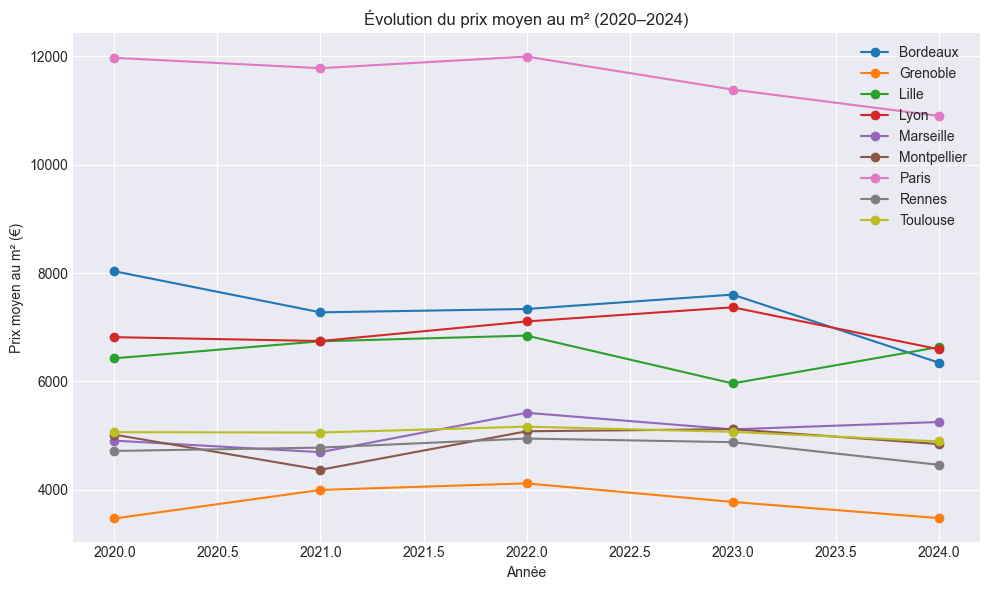

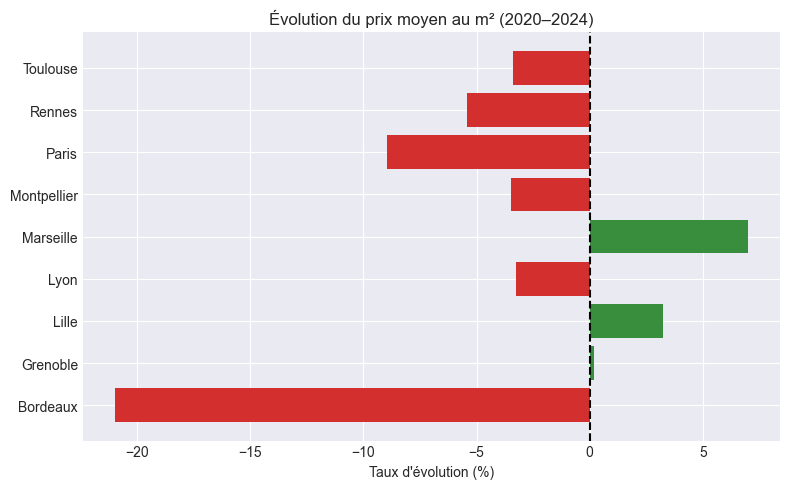

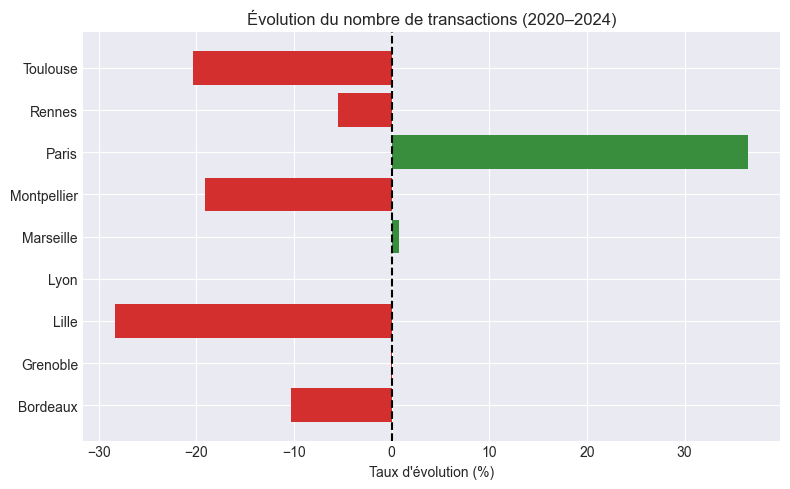

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Récupération dynamique des villes cochées
villes_selectionnees = [cb.description for cb in city_checkboxes if cb.value]

# Vérification
villes_existantes = [v for v in villes_selectionnees if v in df['ville'].unique()]
if not villes_existantes:
    print("⚠️ Aucune ville valide sélectionnée.")
else:
    print(f"Affichage des données pour : {', '.join(villes_existantes)}\n")

    # --------------------------------------------------------------------
    # 1️⃣ ÉVOLUTION DU PRIX MOYEN AU M²
    # --------------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    for ville in villes_existantes:
        data = df[df['ville'] == ville].sort_values('annee')
        plt.plot(data['annee'], data['prix_m2_moyen'], marker='o', label=ville)
    plt.title("Évolution du prix moyen au m² (2020–2024)")
    plt.xlabel("Année")
    plt.ylabel("Prix moyen au m² (€)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------
    # 2️⃣ TAUX D'ÉVOLUTION DU PRIX (2020 → 2024)
    # --------------------------------------------------------------------
    evol_prix = []
    for ville in villes_existantes:
        data = df[df['ville'] == ville]
        p2020 = data[data['annee'] == 2020]['prix_m2_moyen']
        p2024 = data[data['annee'] == 2024]['prix_m2_moyen']
        if len(p2020) and len(p2024) and p2020.iloc[0] != 0:
            taux = ((p2024.iloc[0] - p2020.iloc[0]) / p2020.iloc[0]) * 100
            evol_prix.append((ville, taux))
    if evol_prix:
        villes_graph, taux_graph = zip(*evol_prix)
        plt.figure(figsize=(8, 5))
        plt.barh(villes_graph, taux_graph, color=['#388E3C' if x >= 0 else '#D32F2F' for x in taux_graph])
        plt.title("Évolution du prix moyen au m² (2020–2024)")
        plt.xlabel("Taux d'évolution (%)")
        plt.axvline(x=0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()

    # --------------------------------------------------------------------
    # 3️⃣ ÉVOLUTION DU NOMBRE DE TRANSACTIONS
    # --------------------------------------------------------------------
    evol_trans = []
    for ville in villes_existantes:
        data = df[df['ville'] == ville]
        t2020 = data[data['annee'] == 2020]['nb_transactions']
        t2024 = data[data['annee'] == 2024]['nb_transactions']
        if len(t2020) and len(t2024) and t2020.iloc[0] != 0:
            taux = ((t2024.iloc[0] - t2020.iloc[0]) / t2020.iloc[0]) * 100
            evol_trans.append((ville, taux))

    if evol_trans:
        villes_graph, taux_graph = zip(*evol_trans)
        taux_graph = np.array(taux_graph, dtype=float)
        plt.figure(figsize=(8, 5))
        plt.barh(villes_graph, taux_graph, color=['#388E3C' if x >= 0 else '#D32F2F' for x in taux_graph])
        plt.title("Évolution du nombre de transactions (2020–2024)")
        plt.xlabel("Taux d'évolution (%)")
        plt.axvline(x=0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Pas de données suffisantes pour afficher les transactions.")
